<a href="https://colab.research.google.com/github/kamilenovaes/machine-learning-python/blob/main/notebooks/03_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📘 Regressão Logística


## 🎯 Objetivos

- Usar **Regressão Logística** para **classificação binária**
- Fazer **pré-processamento** (seleção de features + padronização)
- Treinar e avaliar um modelo em um **dataset realista** (churn de clientes)

> **Ideia central:** em vez de prever um número (como na regressão linear), aqui queremos prever uma **classe**:  
> **0 = não sai** / **1 = sai (churn)**.


## 1. Bibliotecas


In [ ]:
# (Opcional)
# !pip -q install numpy pandas scikit-learn matplotlib


In [1]:
# Imports principais
import pandas as pd
import numpy as np

# Treino/teste
from sklearn.model_selection import train_test_split

# Modelo
from sklearn.linear_model import LogisticRegression

# Padronização (média 0, desvio 1)
from sklearn.preprocessing import StandardScaler

# Métrica
from sklearn.metrics import log_loss

# Visualização
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")


## 2. Contexto do problema

"Imagine que você trabalha em uma empresa de telecom. O time percebeu que muitos clientes estão cancelando o serviço (**churn**)."

O objetivo é treinar um modelo que, dado o perfil/uso do cliente, estime a chance dele **sair (1)** ou **ficar (0)**.

> Por que isso importa?  
> Normalmente é **mais barato reter** clientes do que adquirir novos. Se você prevê quem tem alto risco de churn,
> pode agir antes (ofertas, suporte proativo, etc.).


## 3. Carregando os dados

O dataset `ChurnData.csv` é um arquivo hipotético com informações demográficas e de uso do serviço.
Cada linha é um cliente.

Abaixo, carregamos direto por uma URL.


In [2]:
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/ChurnData.csv"
churn_raw = pd.read_csv(url)

# preview
churn_raw.head()


,tenure,age,address,income,ed,employ,equip,callcard,wireless,longmon,...,pager,internet,callwait,confer,ebill,loglong,logtoll,lninc,custcat,churn
0,11.0,33.0,7.0,136.0,5.0,5.0,0.0,1.0,1.0,4.40,...,1.0,0.0,1.0,1.0,0.0,1.482,3.033,4.913,4.0,1.0
1,33.0,33.0,12.0,33.0,2.0,0.0,0.0,0.0,0.0,9.45,...,0.0,0.0,0.0,0.0,0.0,2.246,3.240,3.497,1.0,1.0
2,23.0,30.0,9.0,30.0,1.0,2.0,0.0,0.0,0.0,6.30,...,0.0,0.0,0.0,1.0,0.0,1.841,3.240,3.401,3.0,0.0
3,38.0,35.0,5.0,76.0,2.0,10.0,1.0,1.0,1.0,6.05,...,1.0,1.0,1.0,1.0,1.0,1.800,3.807,4.331,4.0,0.0
4,7.0,35.0,14.0,80.0,2.0,15.0,0.0,1.0,0.0,7.10,...,0.0,0.0,1.0,1.0,0.0,1.960,3.091,4.382,3.0,0.0


## 4. Pré-processamento


- **Target (y):** `churn` (0 ou 1)
- **Features (X):** algumas colunas numéricas como `tenure`, `age`, `income`, etc.

Garantimos que `churn` seja inteiro, como muitos algoritmos esperam.


In [3]:
# Features usadas no modelo
base_features = ["tenure", "age", "address", "income", "ed", "employ", "equip"]
target = "churn"

# Seleciona só o necessário
churn_df = churn_raw[base_features + [target]].copy()

# Garante que o target é inteiro (0/1)
churn_df[target] = churn_df[target].astype(int)

churn_df.head()


,tenure,age,address,income,ed,employ,equip,churn
0,11.0,33.0,7.0,136.0,5.0,5.0,0.0,1
1,33.0,33.0,12.0,33.0,2.0,0.0,0.0,1
2,23.0,30.0,9.0,30.0,1.0,2.0,0.0,0
3,38.0,35.0,5.0,76.0,2.0,10.0,1.0,0
4,7.0,35.0,14.0,80.0,2.0,15.0,0.0,0


## 5. Separando X (entradas) e y (alvo)

- `X` será uma matriz com as colunas de entrada (features)
- `y` será um vetor com a classe verdadeira (`churn`)


In [4]:
X = churn_df[base_features].to_numpy()
y = churn_df[target].to_numpy()

X[:5], y[:5]


(array([[ 11.,  33.,   7., 136.,   5.,   5.,   0.],
        [ 33.,  33.,  12.,  33.,   2.,   0.,   0.],
        [ 23.,  30.,   9.,  30.,   1.,   2.,   0.],
        [ 38.,  35.,   5.,  76.,   2.,  10.,   1.],
        [  7.,  35.,  14.,  80.,   2.,  15.,   0.]]),
 array([1, 1, 0, 0, 0]))

## 6. Padronização (StandardScaler)

**Padronizar** features numéricas para que todas fiquem na mesma escala.

Isso ajuda porque:
- evita que uma variável com valores muito grandes domine as outras
- pode acelerar o treinamento e melhorar a estabilidade numérica


In [5]:
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

X_norm[:5]


array([[-1.13518441, -0.62595491, -0.4588971 ,  0.4751423 ,  1.6961288 ,
        -0.58477841, -0.85972695],
       [-0.11604313, -0.62595491,  0.03454064, -0.32886061, -0.6433592 ,
        -1.14437497, -0.85972695],
       [-0.57928917, -0.85594447, -0.261522  , -0.35227817, -1.42318853,
        -0.92053635, -0.85972695],
       [ 0.11557989, -0.47262854, -0.65627219,  0.00679109, -0.6433592 ,
        -0.02518185,  1.16316   ],
       [-1.32048283, -0.47262854,  0.23191574,  0.03801451, -0.6433592 ,
         0.53441472, -0.85972695]])

## 7. Dividindo em treino e teste

- 80% para treino
- 20% para teste


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X_norm, y, test_size=0.2, random_state=4
)

X_train.shape, X_test.shape


((160, 7), (40, 7))

## 8. Treinando a Regressão Logística

Apesar do nome, a regressão logística é um **classificador**:
- ela estima **probabilidades** da classe 1
- a decisão final (0/1) costuma usar um limiar (default **0.5**)



In [7]:
LR = LogisticRegression(max_iter=1000)
LR.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

## 9. Fazendo previsões

- `predict`: retorna a classe (0 ou 1)
- `predict_proba`: retorna a **probabilidade** de cada classe

No `predict_proba`:
- coluna 0 = P(classe 0)
- coluna 1 = P(classe 1)


In [8]:
yhat = LR.predict(X_test)
yhat[:10]


array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [9]:
yhat_prob = LR.predict_proba(X_test)
yhat_prob[:10]


array([[0.74643946, 0.25356054],
       [0.92667894, 0.07332106],
       [0.83442627, 0.16557373],
       [0.94600618, 0.05399382],
       [0.84325532, 0.15674468],
       [0.71448367, 0.28551633],
       [0.77076426, 0.22923574],
       [0.90955642, 0.09044358],
       [0.26152115, 0.73847885],
       [0.94900731, 0.05099269]])

## 10. Interpretando coeficientes (o “peso” de cada feature)

Em uma regressão logística:
- coeficiente **positivo** → aumentar essa feature tende a aumentar a chance de churn (classe 1)
- coeficiente **negativo** → aumentar essa feature tende a reduzir a chance de churn
- coeficiente perto de 0 → efeito fraco

> Isso fica mais interpretável quando as features estão na **mesma escala** (por isso padronizamos).


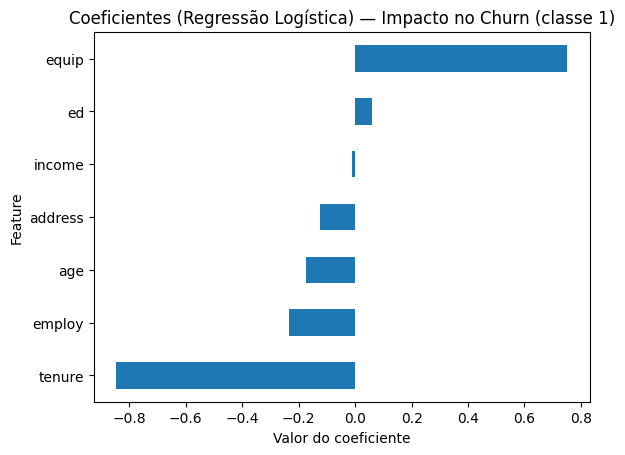

In [10]:
coef = pd.Series(LR.coef_[0], index=base_features).sort_values()

coef.plot(kind="barh")
plt.title("Coeficientes (Regressão Logística) — Impacto no Churn (classe 1)")
plt.xlabel("Valor do coeficiente")
plt.ylabel("Feature")
plt.show()


## 11. Avaliação: Log Loss

Uma métrica importante para modelos probabilísticos é o **Log Loss** (também chamado de *Binary Cross-Entropy*).

Ele penaliza:
- previsões **confiantes e erradas** (pior caso)
- e recompensa probabilidades bem calibradas

Quanto **menor**, melhor.


In [11]:
logloss_base = log_loss(y_test, yhat_prob)
logloss_base


0.6257718410257235

## 12) Exercícios

Função que calcula o **log loss** para qualquer lista de colunas.

### Perguntas
1. Adicionar `callcard`
2. Adicionar `wireless`
3. Adicionar `callcard` e `wireless`
4. Remover `equip`
5. Remover `income` e `employ`

> O objetivo é praticar **engenharia de features** simples e observar como a métrica muda.


In [12]:
def avaliar_logloss(features, test_size=0.2, random_state=4):
    """Treina regressão logística com um conjunto de features e retorna o log loss no teste."""
    df = churn_raw[features + [target]].copy()
    df[target] = df[target].astype(int)

    X = df[features].to_numpy()
    y = df[target].to_numpy()

    X = StandardScaler().fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)

    proba = model.predict_proba(X_test)
    return log_loss(y_test, proba)

# Cenários pedidos
cenarios = {
    "Base": base_features,
    "+ callcard": base_features + ["callcard"],
    "+ wireless": base_features + ["wireless"],
    "+ callcard + wireless": base_features + ["callcard", "wireless"],
    "- equip": [f for f in base_features if f != "equip"],
    "- income - employ": [f for f in base_features if f not in ("income", "employ")],
}

resultados = (
    pd.DataFrame(
        [{"Cenário": nome, "Log loss": avaliar_logloss(feats), "Features": ", ".join(feats)}
         for nome, feats in cenarios.items()]
    )
    .sort_values("Log loss")
    .reset_index(drop=True)
)

resultados


,Cenário,Log loss,Features
0,- equip,0.530243,"tenure, age, address, income, ed, employ"
1,+ callcard,0.603910,"tenure, age, address, income, ed, employ, equi..."
2,Base,0.625772,"tenure, age, address, income, ed, employ, equip"
3,- income - employ,0.652932,"tenure, age, address, ed, equip"
4,+ wireless,0.722705,"tenure, age, address, income, ed, employ, equi..."
5,+ callcard + wireless,0.776056,"tenure, age, address, income, ed, employ, equi..."


### Observações finais

- Se o **log loss diminui**, as probabilidades do modelo ficaram **melhores** (mais alinhadas ao real).
- Se o **log loss aumenta**, as features adicionadas podem estar adicionando ruído, redundância,
  ou simplesmente não ajudam o modelo (pelo menos nesse setup).